### Домашнее задание 2 - 10 баллов

В этом задании вам предстоит продолжить работу с датасетом lenta-ru-news для той же задачи - классификации текстов по топикам. Можно переиспользовать подготовленные данные из ДЗ 1 или загрузить их заново.

1. Разделите датасет на обучающую, валидационную и тестовую выборки со стратификацией в пропорции 60/20/20. В качестве целевой переменной используйте атрибут `topic`
2. Обучите word2vec-эмбеддинги с помощью библиотеки gensim - **2 балла**
  - создайте модель для обучения на ваших данных, опишите, какими значениями вы инициализировали гиперпараметры модели, и почему
  - визуально оцените внутреннее (intrinsic) качество получившихся эмбеддингов, используя методы gensim - doesnt_match, most_similar
3. Загрузите предобученные эмбеддинги из navec и rusvectores (на ваш вкус) - **1 балл**
4. Обучите модель `sklearn.linear_model.LogisticRegression` с тремя вариантами векторизации текстов и сравните их качество между собой на валидационной выборке: **2 балла**
  - ваши эмбеддинги w2v
  - предобученные эмбеддинги navec
  - предобученные эмбеддинги rusvectores
5. Попробуйте улучшить качество модели, взяв для ее обучения лучший набор эмбеддингов и используя его с взвешиванием через tf-idf. То есть, необходимо каждый текст представить в виде взвешенного усреднения эмбеддингов его слов, где весами являются соответствующие коэффициенты tf-idf - **2 балла**
6. Финально сравните качество всех моделей на тестовой выборке - **1 балл**

In [ ]:
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import gensim
from navec import Navec
from gensim.models import Word2Vec

import pymorphy2

## 1. Загружаем датасет

In [4]:
df = pd.read_csv('cleaned-lenta-ru-news-100k.csv')
df.head()

,full_text,topic,cleaned_full_text
0,На британской выставке покажут туфли за 140 ты...,Из жизни,британской выставке покажут туфли тысяч фунтов...
1,"Основатели ""Патэрсона"" создадут сеть торговых ...",Дом,основатели патэрсона создадут сеть торговых це...
2,Производитель ликера Marie Brizard начал перег...,Экономика,производитель ликера начал переговоры покупке ...
3,"""Никотиновый ниндзя"" украл сигарет на 120 тыся...",Из жизни,никотиновый ниндзя украл сигарет тысяч долларо...
4,Дочки «Аэрофлота» сократят количество зарубежн...,Бизнес,дочки аэрофлота сократят количество зарубежных...


In [7]:
# посмотрим на баланс классов

df['topic'].value_counts()

topic
Экономика            9000
Наука и техника      9000
Бывший СССР          9000
Спорт                9000
Культура             9000
Мир                  9000
Россия               9000
Интернет и СМИ       9000
Силовые структуры    6000
Из жизни             5000
Дом                  5000
Бизнес               4000
Ценности             4000
Путешествия          4000
Name: count, dtype: int64

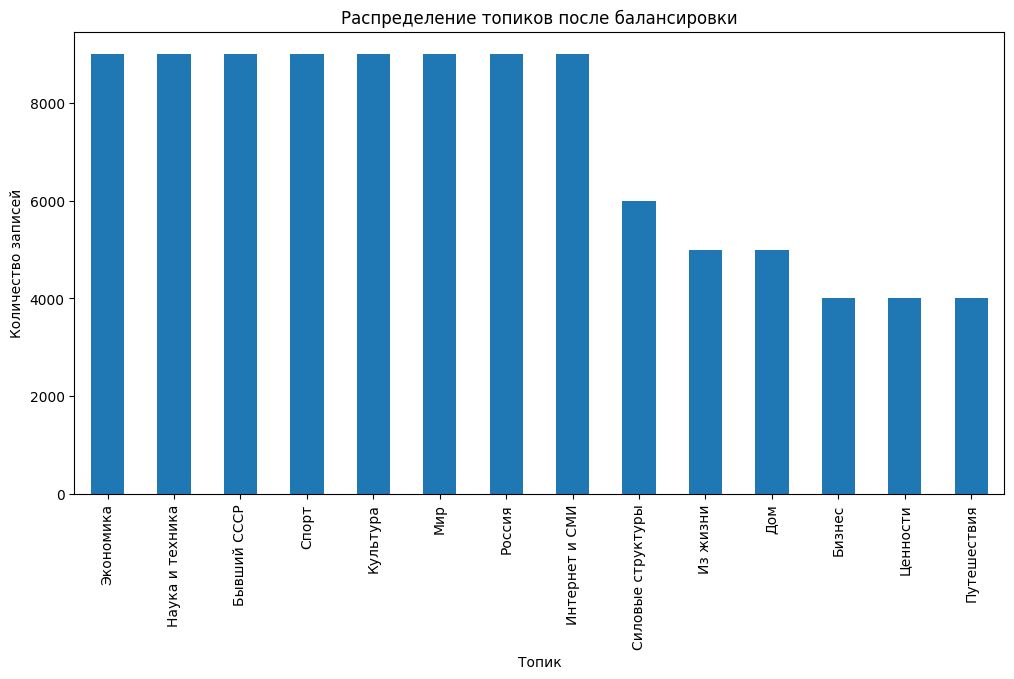

In [9]:
df['topic'].value_counts().plot(kind='bar', figsize=(12, 6))
plt.title('Распределение топиков после балансировки')
plt.xlabel('Топик')
plt.ylabel('Количество записей')
plt.show()

In [17]:
texts = df['cleaned_full_text'].apply(lambda x: x.split())
topics = df['topic']

x_train, x_temp, y_train, y_temp = train_test_split(
    texts, topics, test_size=0.4, stratify=topics, random_state=42
)
x_val, x_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

## 2. Обучим word2vec-эмбеддинги

In [20]:
model_w2v = Word2Vec(
    sentences=x_train,
    vector_size=200,       # для датасетов среднего размера
    window=7,              # контекст для учета более широких связей
    min_count=5,           # Игнорировать редкие слова (меньше шума)
    workers=8,             # Используем имеющиеся ядра
    sg=1,                  # Skip-gram (лучше для семантических связей)
    hs=0,                  # Negative sampling
    negative=15,           # Количество негативных примеров
    alpha=0.03,            # Начальная скорость обучения
    epochs=30              # Эпохи для обучения
)

In [27]:
# Проверка качества эмбеддингов
print("Лишнее слово:", model_w2v.wv.doesnt_match("нейросеть алгоритм градиентный_спуск пицца".split()))

print('*'*10)
print("Самые похожие на слово 'гиперпараметры':")
for word, sim in model_w2v.wv.most_similar("похожие", topn=5):
    print(f"{word}: {sim:.2f}")

Лишнее слово: пицца
**********
Самые похожие на слово 'гиперпараметры':
подобные: 0.49
такие: 0.47
ошибочными: 0.41
сероводород: 0.40
примесями: 0.40


## 3. Загружаем предобученные эмбеддинги из navec и rusvectores

In [38]:
url = 'https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar'
path = 'navec_hudlit_v1_12B_500K_300d_100q.tar'

response = requests.get(url, stream=True)
with open(path, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

navec = Navec.load(path)

In [42]:
navec['семья'][:15]

array([ 0.18638138, -0.27080196, -0.3037158 , -0.40253818,  0.0412746 ,
       -0.29715636,  0.6551529 , -0.43297604,  0.16562702, -0.169193  ,
       -0.13690768, -0.03418645, -0.75437665, -0.02528062, -0.18019031],
      dtype=float32)

In [43]:
url = "https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz"
path = "ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz"

response = requests.get(url, stream=True)
with open(path, "wb") as f:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            f.write(chunk)

rusvectores = gensim.models.KeyedVectors.load_word2vec_format(path)     

In [44]:
rusvectores.most_similar(positive=['счастье_NOUN'], topn=10)

[('счастие_NOUN', 0.7966569662094116),
 ('радость_NOUN', 0.6988434791564941),
 ('счастье_VERB', 0.6570127606391907),
 ('несчастье_NOUN', 0.6543306112289429),
 ('блаженство_NOUN', 0.6470820903778076),
 ('счастливый_ADJ', 0.641209065914154),
 ('удача_NOUN', 0.6353999376296997),
 ('наслажденье_NOUN', 0.6323317289352417),
 ('счастья_NOUN', 0.6166901588439941),
 ('наслаждение_NOUN', 0.6114725470542908)]

## 4. Обучим модель sklearn.linear_model.LogisticRegression с тремя вариантами векторизации текстов и сравним их качество между собой на валидационной выборке.

In [71]:
# векторизируем

def vectorize(texts, word_vectors, dim=200):
    vectors = []
    for text in tqdm(texts):
        vec = np.zeros(dim)
        valid_words = 0
        for word in text:
            if word in word_vectors:
                vec += word_vectors[word]
                valid_words += 1
        if valid_words > 0:
            vec /= valid_words
        vectors.append(vec)
    return np.array(vectors)

In [73]:
# векторизируем с помощью word2vec и navec
x_train_w2v = vectorize(x_train, model_w2v.wv)
x_val_w2v = vectorize(x_val, model_w2v.wv)

x_train_navec = vectorize(x_train, navec, dim=300)
x_val_navec = vectorize(x_val, navec, dim=300)

100%|████████████████████████████████████████| 20000/20000 [00:13<00:00, 1434.46it/s]


In [77]:
# Для rusvectores определения тега части речи, используем pymorphy2, а потом векторизируем


def get_lemma_with_pos(word):
    parsed = morph.parse(word)[0]  # Берем наиболее вероятный разбор
    lemma = parsed.normal_form
    pos = parsed.tag.POS or 'UNKN'  # Часть речи или UNKN если не определена
    
    return lemma, pos # По умолчанию считаем NOUN

def vectorize_rusvectores(texts, word_vectors, dim=300):
    vectors = []
    for text in tqdm(texts):
        vec = np.zeros(dim)
        valid_words = 0
        for word in text:
            lemma, pos = get_lemma_with_pos(word)
            key = f"{lemma}_{pos}"
            
            # Пробуем найти вектора в порядке приоритета: lemma_POS -> lemma_NOUN -> lemma
            if key in word_vectors:
                vec += word_vectors[key]
                valid_words += 1
            else:
                key_fallback = f"{lemma}_NOUN"
                if key_fallback in word_vectors:
                    vec += word_vectors[key_fallback]
                    valid_words += 1
                elif lemma in word_vectors:
                    vec += word_vectors[lemma]
                    valid_words += 1

        if valid_words > 0:
            vec /= valid_words
        vectors.append(vec)
    return np.array(vectors)




morph = pymorphy2.MorphAnalyzer()

x_train_rusvec = vectorize_rusvectores(X_train, rusvectores)
x_val_rusvec = vectorize_rusvectores(X_val, rusvectores)

100%|██████████████████████████████████████████| 20000/20000 [04:35<00:00, 72.50it/s]


In [86]:
# Проверим
sample_text = ['утром', 'быстро', 'бежать']
for word in sample_text:
    lemma, pos = get_lemma_with_pos(word)
    print(f"{word} -> {lemma}_{pos}")

# Тестирование похожих слов с учетом POS-тегов
print("ночь (как NOUN):", rusvectores.most_similar('ночь_NOUN', topn=3))
print("ночь (как ADV):", rusvectores.most_similar('ночь_ADV', topn=3))

утром -> утром_ADVB
быстро -> быстро_ADVB
бежать -> бежать_INFN
ночь (как NOUN): [('ночь_PROPN', 0.7704508304595947), ('вечер_NOUN', 0.7683228254318237), ('утро_NOUN', 0.7520124316215515)]
ночь (как ADV): [('ночь_VERB', 0.6284437775611877), ('ночь_NOUN', 0.6248846650123596), ('ночь_PROPN', 0.6179807186126709)]


In [87]:
lr_w2v = LogisticRegression(max_iter=1000)
lr_w2v.fit(x_train_w2v, y_train)
y_pred_w2v = lr_w2v.predict(x_val_w2v)

lr_navec = LogisticRegression(max_iter=1000)
lr_navec.fit(x_train_navec, y_train)
y_pred_navec = lr_navec.predict(x_val_navec)

lr_rusvec = LogisticRegression(max_iter=1000)
lr_rusvec.fit(x_train_rusvec, y_train)
y_pred_rusvec = lr_rusvec.predict(x_val_rusvec)


print("Accuracy (w2v):", accuracy_score(y_val, y_pred_w2v))
print("Accuracy (navec):", accuracy_score(y_val, y_pred_navec))
print("Accuracy (rusvectores):", accuracy_score(y_val, y_pred_rusvec))

Accuracy (w2v): 0.7939
Accuracy (navec): 0.75425
Accuracy (rusvectores): 0.7095


word2vec плказал лучшие результаты

## 5. Попробуем улучшить качество модели, взяв для ее обучения лучший набор эмбеддингов и используя его с взвешиванием через tf-idf. То есть, необходимо каждый текст представить в виде взвешенного усреднения эмбеддингов его слов, где весами являются соответствующие коэффициенты tf-idf


In [91]:
# Создание TF-IDF матрицы
tfidf = TfidfVectorizer(tokenizer=lambda x: x, preprocessor=lambda x: x, token_pattern=None)
tfidf.fit(X_train)

TfidfVectorizer(preprocessor=<function <lambda> at 0x7f0f25580dc0>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x7f0f256ac430>)

In [96]:
# Взвешенное усреднение с TF-IDF
def vectorize_tfidf(texts, word_vectors, tfidf, dim=200):
    vectors = []
    vocab = {word: idx for idx, word in enumerate(tfidf.get_feature_names_out())}
    for text in tqdm(texts):
        vec = np.zeros(dim)
        total_weight = 0
        tfidf_features = tfidf.transform([text]).toarray()[0]
       
        for word in text:
            if word in vocab and word in word_vectors:
                weight = tfidf_features[vocab[word]]
                vec += word_vectors[word] * weight
                total_weight += weight
        if total_weight > 0:
            vec /= total_weight
        vectors.append(vec)
    return np.array(vectors)

In [97]:
x_train_w2v_tfidf = vectorize_tfidf(x_train, model_w2v.wv, tfidf)
x_val_w2v_tfidf = vectorize_tfidf(x_val, model_w2v.wv, tfidf)

100%|████████████████████████████████████████| 20000/20000 [00:18<00:00, 1101.46it/s]


In [98]:
lr_w2v_tfidf = LogisticRegression(max_iter=1000)
lr_w2v_tfidf.fit(x_train_w2v_tfidf, y_train)
y_pred_tfidf = lr_w2v_tfidf.predict(x_val_w2v_tfidf)
print("Accuracy (TF-IDF + w2v):", accuracy_score(y_val, y_pred_tfidf))

Accuracy (TF-IDF + w2v): 0.76835


## 6. Финально сравните качество всех моделей на тестовой выборке

In [102]:
x_test_w2v = vectorize(x_test, model_w2v.wv)
x_test_w2v_tfidf = vectorize_tfidf(x_test, model_w2v.wv, tfidf)
x_test_navec = vectorize(x_test, navec, dim=300)
x_test_rusvec = vectorize_rusvectores(x_test, rusvectores)

y_pred_test_w2v = lr_w2v.predict(x_test_w2v)
y_pred_test_w2v_tfidf = lr_w2v_tfidf.predict(x_test_w2v_tfidf)
y_pred_test_navec = lr_navec.predict(x_test_navec)
y_pred_test_rusvec = lr_rusvec.predict(x_test_rusvec)

print("Accuracy (w2v):", classification_report(y_test, y_pred_test_w2v))
print("Accuracy (TF-IDF + w2v):", classification_report(y_test, y_pred_test_w2v_tfidf))
print("Accuracy (navec):", classification_report(y_test, y_pred_test_navec))
print("Accuracy (rusvectores):", classification_report(y_test, y_pred_test_rusvec))

100%|██████████████████████████████████████████| 20000/20000 [04:35<00:00, 72.52it/s]


Accuracy (w2v):                    precision    recall  f1-score   support

           Бизнес       0.70      0.56      0.63       800
      Бывший СССР       0.84      0.84      0.84      1800
              Дом       0.86      0.82      0.84      1000
         Из жизни       0.64      0.65      0.64      1000
   Интернет и СМИ       0.76      0.73      0.74      1800
         Культура       0.86      0.89      0.87      1800
              Мир       0.73      0.78      0.76      1800
  Наука и техника       0.84      0.85      0.85      1800
      Путешествия       0.83      0.81      0.82       800
           Россия       0.65      0.65      0.65      1800
Силовые структуры       0.80      0.77      0.79      1200
            Спорт       0.96      0.96      0.96      1800
         Ценности       0.91      0.89      0.90       800
        Экономика       0.76      0.82      0.78      1800

         accuracy                           0.80     20000
        macro avg       0.80      0.79

Вывод: судя по всему word2vec лучше всех справляется с поставленной задачей.